# Scarlet Lite Tutorial

The main scarlet module was designed to allow users to create a wide range of models, including simple bulge-disk galaxies, point source models, sersic models, wavelet models, and other user defined models. While the built-in initialization function `scarlet.initialization.init_all_sources` only builds the simplest extended source models, even it accepts a wide range of observations including photometric data (potentially from different cameras at different resolutions and projections), spectral data, and combinations of all the above.

While that makes scarlet a powerful tool for a wide range of astronomical data analysis, quite often the data that we are working with is much more uniform. In many (most?) cases users have data from a single instrument that has been reprojected onto a common WCS in all bands to make multi-color photometric images. Further, if the user is modeling a large area of the sky, there is likely to be less customization of models and a simple bulge-disk model like the scarlet `ExtendedSource` model with a small number of components is sufficient. When you can assume that the data is all in the same bounding box, at the same resolution, and you have models with gradients that you can calculate analytically, using `scarlet.lite` as opposed to baseline `scarlet` is likely to run several times faster using an order of magnitude less memory. This tutorial wll describe how to use `scarlet.lite` and outline some of the differences between creating, fitting, and visualizing scarlet lite models as opposed to baseline scarlet.

# Design

The overal design of scarlet lite is significantly different than baseline scarlet. In the main module, scarlet was designed to be hierarchical, with `scarlet.model.Model` as the base class that all of the other models are constructed from. This design is beneficial for users that have a wide variety of very complicated models and makes it efficient to use an automatic gradient code like [autograd](https://github.com/HIPS/autograd) to optimize over a wide variety of parameters.

In scarlet lite the code is designed to be modular, so much so that the bulk of the code is functional as opposed to object oriented. Regardless of the optimizer used and the types models the user creates, nearly all of of the initialization code is built from modular functions that operate on numpy arrays, making it easy to reuse code with little copying and pasting. This makes it easier to implement new models, optimizers, and test differences between them, provided you can calculate gradients for all of the parameters analytically and that all of the observations are reprojected onto the same WCS.

This modularity extends to `LiteParameter`s. Similar to baseline scarlet's `Parameter` class, a `LiteParameter` is a parameter that can be updated using an optimization algorithm. But unlike baseline scarlet, where the parameters are hard coded for the adaprox implementation of ADAM, in scarlet lite all of the optimization, including gradient updates and proximal operators, is implemented in the `LiteParameter` class. So a set of sed and morphology arrays can be initialized and then converted into parameters that use any valid gradient descent update method, as we'll see in [Parameterization](#Parameterization).

## Initialization

Initializing scarlet lite models consists of several steps. For users who intend to use only the built-in scarlet models most of these steps will be hidden inside of convenience functions that put them all together, but it's useful to understand the different steps that can be used in case you want to develop your own initialization method and models.

The remainder of this section (and most of this tutorial) will asssume that users are using models that are decomposed into a morphology multiplied by an intensity (SED) in each band, with one or more components. While this is not required for scarlet lite to work, this is the most common use case right now and is the way that all of the built-in initialization schemes have been designed.

### Pre-processing

#### Data reduction

The first steps in initializing your models are required to be performed before running scarlet lite. All of the built-in routines assume that the data comes in the form of a 3D image cube with dimension `(bands, height, width)`, so that the image in each band has been reprojected onto the same WCS, with the same orientation, pixel size, and footprint. The image data should also have a `variance` map with the same dimensions as the input image data and a weight map, typically the inverse variance with perhaps some pixels masked out, and a precomputed PSF in each band, where again the PSF is that same pixel scale, width, and height in each band. You'll also need to choose a model PSF array, which is typically a Gaussian that is narrower than the observed PSF in each band. scarlet hasn't been tested with undersampled data, so if you are dealing with undersampled images then you will probably experience unexpected results. Once those objects have been loaded they should be passed to a `LiteObservation` instance:

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# place the origin at the lower left corner
matplotlib.rc('image', origin='lower')

from scarlet.lite import LiteObservation, integrated_circular_gaussian

# Ignore divide by zero errors that occur in logarithms
np.seterr(divide='ignore')

# For this tutorial we load the scarlet example data
data = np.load("hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
variance = data["variance"]
weights = 1/data["variance"]
psfs = data["psfs"]

# We use a well sampled but small PSF for the model
model_psf = integrated_circular_gaussian(sigma=0.8)

# Create the LiteObservation to contain the data
observation = LiteObservation(images, variance, weights, psfs, model_psf[None, :, :])

#### Detection

Typically detection is done outside of scarlet in the same data reduction pipeline that reprojected the images and created the PSFs. But in blended regions those detection algorithms can fail and we hope to have a working detetion solution implemented in scarlet in the near future. Because deblending with scarlet is highly dependent on detection of all sources in the blend, in this section we use a piece of code in scarlet that is still a work in progress but does do a better job than most pipelines at detecting faint sources next to much brighter neighbors. The details of this cell are beyond ths scope of this tutorial.

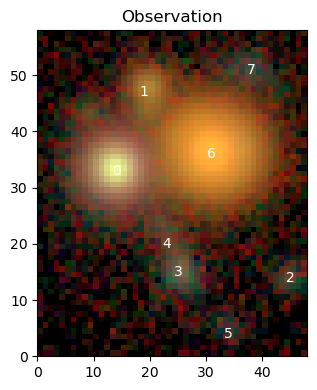

In [2]:
import scarlet
import scarlet.lite.display as display

# Get a set of wavelets for detection
detect = scarlet.detect.get_detect_wavelets(images, variance, scales=3)
# Detect a hierarchy of structures in the wavelet coefficients
structures, middle_tree = scarlet.detect.get_blend_structures(detect)

# Extract all of the peaks from the structures
centers = []
for box in middle_tree.query(observation.bbox[1:]):
    for peak in box.footprint.peaks:
        centers.append((peak.y, peak.x))

# Display the sources
stretch = 0.2
Q = 10
norm = display.AsinhMapping(minimum=0, stretch=stretch, Q=Q)
display.show_observation(observation, sky_coords=centers, norm=norm)
plt.show()

### Initialization coadd

In order to create a morphology that is the same in all bands we want to initialize it using a 2D detection image.
$\chi^2$ or Kaiser coadds are optimal for detecting peak positions of sources and we have found that a similar image is sufficient for initializing our models. When a `LiteObservation` instance is created it calculates the mean RMS in each band, so we can use that to build a $\chi^2$ coadd using

/tmp/ipykernel_938/3206078.py:4: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(detect))


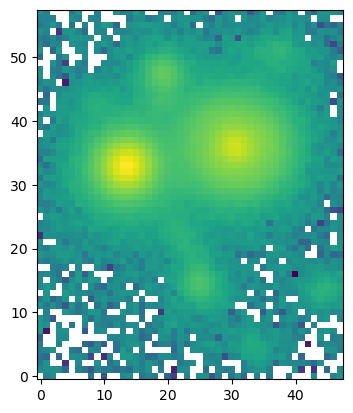

In [3]:
detect = np.sum(observation.images/(observation.noise_rms**2)[:, None, None], axis=0)

# Show the detection image
plt.imshow(np.log10(detect))
plt.show()

Another option is to use wavelet coefficients for initialization, which can be useful to initialize bulge-disk galaxies because the higher frequency scales can be used to initialize the bulge while the lower frequency scales can be used to initialize the disk. So first we create the wavelets

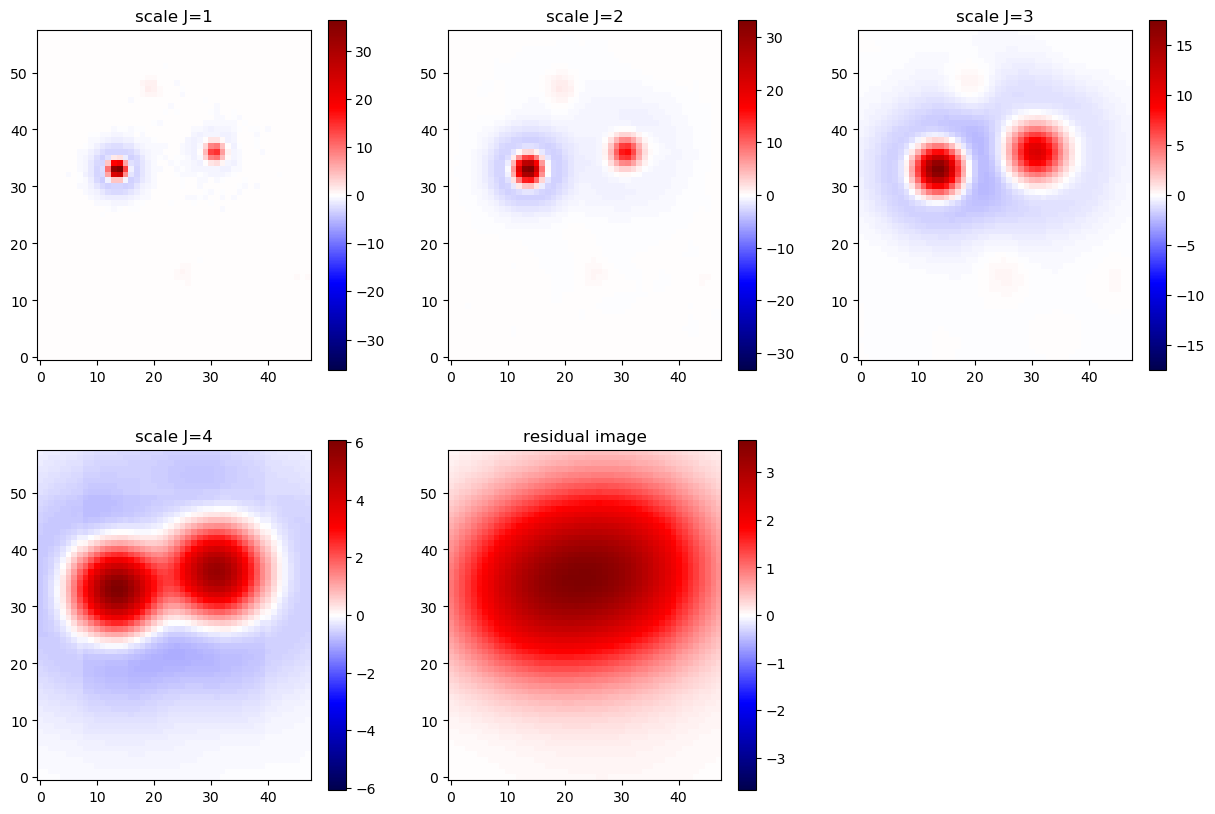

In [4]:
from scarlet.detect import get_detect_wavelets

# Scales is the number of wavelet scales to use.
# The dimensions of `wavelets` will be `(scales+1, width, height)`,
# where the last dimension is the residual image with all of the
# scales greater than `scales`.
wavelets = get_detect_wavelets(observation.images, observation.variance, scales=4)

fig = plt.figure(figsize=(15,10))
ax = [fig.add_subplot(2, 3, n) for n in range(1,6)]
for c, coeffs in enumerate(wavelets):
    vmax = np.max(np.abs(coeffs))
    im = ax[c].imshow(coeffs, vmin=-vmax, vmax=vmax, cmap="seismic")
    plt.colorbar(im, ax=ax[c])
    if c != 4:
        ax[c].set_title(f"scale J={c+1}")
    else:
        ax[c].set_title(f"residual image")
plt.show()

A full discussion of the starlet wavelet, a.ka. the isotropic undecimated wavelet transform, is outside the scope of this tutorial. The key features that should be pointed out are that each source is bright in the center with a negative ring around it. So by using only the positive part of the wavelet coefficients we have a pseudo deconvolution that will help keep our sources more compact than if we initialize them using the detection image. It also allows us a simple way to initialize two component models, where (for example) we can use the first two wavelet scales to initialize the bulge and the next two to initialize the disk:

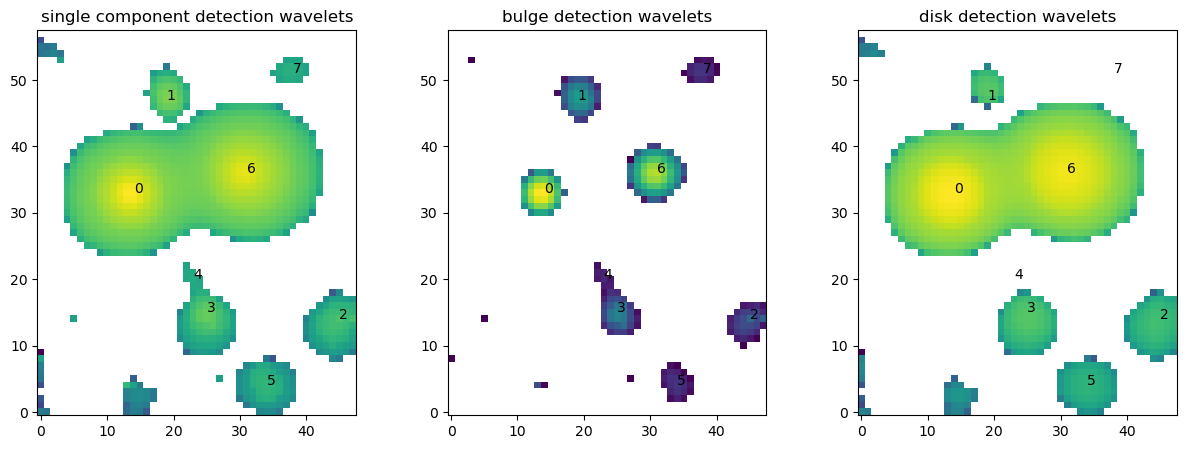

In [5]:
# Remove the negative coefficients.
# This is done to prevent bright source with wide negative rings
# from swallowing fainter sources detectable at other wavelet scales
wavelets[wavelets < 0] = 0
# Initialization image for single component sources
detectlets = np.sum(wavelets[:-1], axis=0)
# Initialization image for the bulge
bulgelets = np.sum(wavelets[:2], axis=0)
# Initialization image for the disk
disklets = np.sum(wavelets[2:-1], axis=0)

# Display the different detection images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(detectlets))
ax[1].imshow(np.log10(bulgelets))
ax[2].imshow(np.log10(disklets))
for k, center in enumerate(centers):
    ax[0].text(*center[::-1], k, color="k")
    ax[1].text(*center[::-1], k, color="k")
    ax[2].text(*center[::-1], k, color="k")
ax[0].set_title("single component detection wavelets")
ax[1].set_title("bulge detection wavelets")
ax[2].set_title("disk detection wavelets")
plt.show()

### Morphology

For a given peak location the next step is to create an estimate of the morphology. Like baseline scarlet, the model for each source will exist in an image with a narrower PSF than the PSF in any of the observations, so ideally we would want to initialize the morphology in a deconvolved way. In practice this proves difficult and so far we haven't found a stable algorithm that initializes a deconvolved morphology fast enough to be worth doing, however the wavelet detection images created above are a semi-decent approximation.

The `init_monotonic_morph` function can be used to create the initial morphology for a single source by using one of two algorithms. The `monotonic_mask` initialization starts at the peak location of a source and masks out all of the pixels that are not monotonically decreasing from the center along some (potentially curved) path. This allows the initial model to include features like spiral arms and tails between interacting galaxies. The other option is to use the monotonicity constraint that is used in both baseline scarlet and in the scarlet lite proximal operators to project morphology radially outward from the center, with the option to make the initial model symmetric to limit the size of its initial footprint.

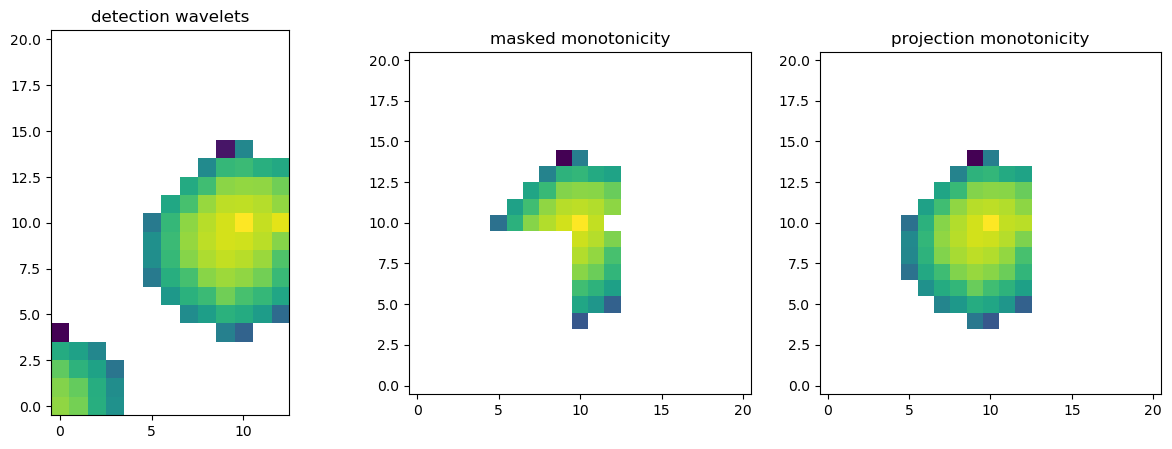

In [6]:
from scarlet.lite import init_monotonic_morph

# create a morphology using a monotonic mask
masked_box, masked_morph = init_monotonic_morph(
    detectlets.copy(), centers[2], observation.bbox[1:])
# create a morphology using a monotonic projection
project_box, project_morph = init_monotonic_morph(
    detectlets.copy(), centers[2], observation.bbox[1:], use_mask=False)

# display the morphologies
overlap = observation.bbox[1:] & masked_box
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(detectlets[overlap.slices]))
ax[0].set_title("detection wavelets")
ax[1].imshow(np.log10(masked_morph))
ax[1].set_title("masked monotonicity")
ax[2].imshow(np.log10(project_morph))
ax[2].set_title("projection monotonicity")
plt.show()

### SED

Initializing the SED will depend on the type of model to be initialized. Because the model is convolved with a difference kernel in each band to compare it to observations and build gradient updates, the SED at the peak of the model will differ from the SED of the peak pixel after it has been convolved in each band. When possible it is recommended to create the morphology of all of the components and then simultaneously fit the SEDs using a least squares algorithm, however for blends with a large number of sources and/or a large spatial area (in terms of pixels) that operation might be too computationally expensive.

#### Single component sources

A good way to initialize the SED for single component sources is to convolve the morphology in each band and weigh the observed image at the peak location with the convolved morphology in the same location. So for built-in single component initialization functions this is the method used to obtain the SEDs, except for two component galaxies where both components are simultaneously fit.

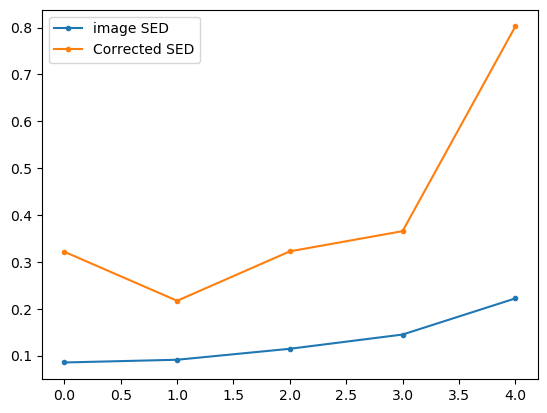

In [7]:
from scarlet.lite import insert_image

morph = insert_image(observation.bbox[1:], project_box, project_morph)

# Create a convolved version of the morphology
convolved = observation.convolve(
    np.repeat(morph[None, :, :],
    observation.shape[0], axis=0),
    mode="real"
)

# Correct the image SED with the convolved morphology
sed_slice = (slice(None), *centers[2])
image_sed = images[sed_slice]
model_sed = images[sed_slice] / convolved[sed_slice]

# Show the difference in each band
plt.plot(image_sed, ".-", label="image SED")
plt.plot(model_sed, ".-", label="Corrected SED")
plt.legend()
plt.show()

To test that this is a valid estimate, we create the model for the first morphology and show that it is the same as the observed image.

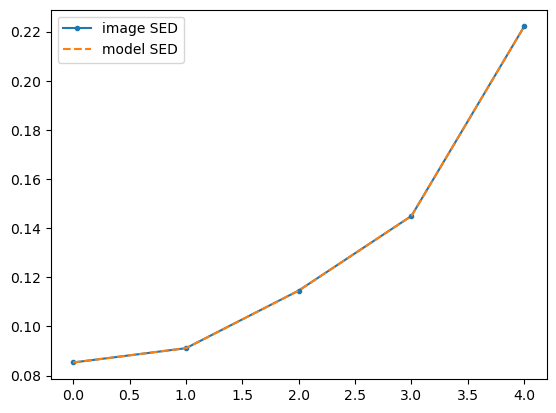

In [8]:
model = model_sed[:, None, None] * morph
model = observation.convolve(model)

plt.plot(image_sed, ".-", label="image SED")
plt.plot(model[sed_slice], "--", label="model SED")
plt.legend()
plt.show()

#### Two component sources

For bulge-disk sources (or more complicated sources) the seds should be fit using the `multifit_seds` method to fit both SEDs simultaneously. This will fail if the morphologies are degenerate, or if one of them is null, so it is wise to check that in advance and fallback to a single component initialization in that case.

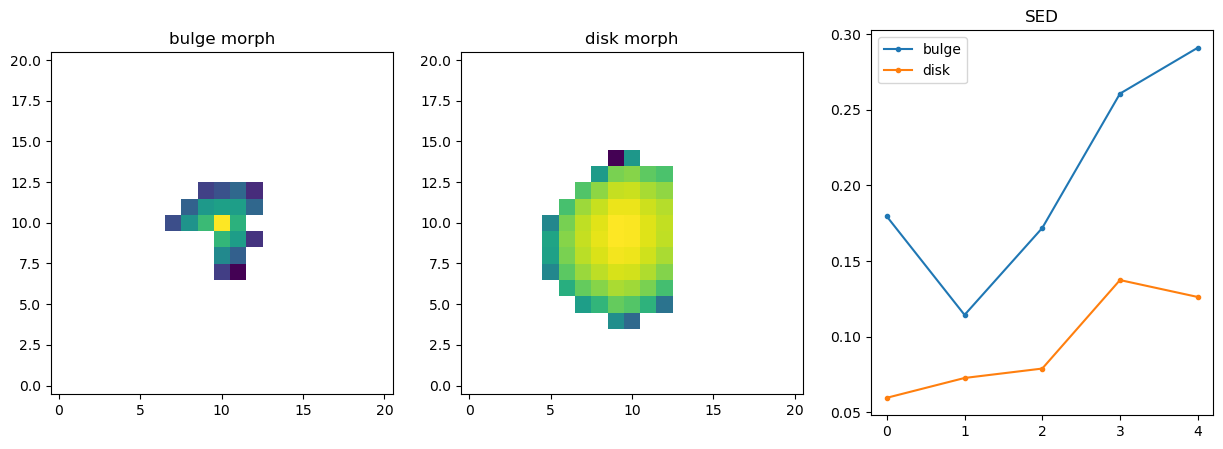

In [9]:
from scarlet.lite import multifit_seds

# initialize a bulge morphology
bulge_box, bulge_morph = init_monotonic_morph(
    bulgelets.copy(), centers[2], observation.bbox[1:])
# initialize a disk morphology
disk_box, disk_morph = init_monotonic_morph(
    disklets.copy(), centers[2], observation.bbox[1:])
# fit the seds
bulge_sed, disk_sed = multifit_seds(observation, [bulge_morph, disk_morph], [bulge_box, disk_box])

# display the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(bulge_morph))
ax[1].imshow(np.log10(disk_morph))
ax[2].plot(bulge_sed, ".-", label="bulge")
ax[2].plot(disk_sed, ".-", label="disk")
ax[0].set_title("bulge morph")
ax[1].set_title("disk morph")
ax[2].set_title("SED")
plt.legend()
plt.show()

### Sources

In scarlet lite, unlike baseline scarlet, a source is basically just a bookeeping tool. It contains a list of components (perhaps no components if initialization failed at the given peak location) and the necessary methods to project all of its component models into a common bounding box. It is possible to make it more complicated but doing so would require the user to subclass `LiteBlend` and override the `fit` method to iterate over sources instead of components, which it does for performance reasons.

All of the above steps can be run simultaneously to create that list of sources using one of the following convenience functions, which builds an initialization image and intializes the morphology and SED for each source.

In [10]:
from scarlet.lite import init_all_sources_main, init_all_sources_wavelets

main_sources = init_all_sources_main(observation, centers)
wavelet_sources = init_all_sources_wavelets(observation, centers)

### Components

Once the SED and morphology arrays are calculated for a given component they are combined in a `LiteComponent` object. This base class is just a place holder, as it doesn't contain any information about gradient updates, proximal operators, or even how to build the model from the SED and morphology. While you are free to use any type of model you wish for components, the important thing about the component class that you create is that it should know how to create a gradient update for the SED, morphology, and any other parameters that your model requires. Unlike baseline scarlet, for performance and memory reasons scarlet lite does not import autograd, so it will not do this for you. In the case of simple SED & morphology decompositions the `LiteFactorizedComponent` is sufficient.

We can see the components of the above sources if we print them out:

In [11]:
for src in main_sources:
    print(src.components)

[LiteComponent, LiteComponent]
[LiteComponent, LiteComponent]
[LiteComponent]
[LiteComponent]
[LiteComponent]
[LiteComponent]
[LiteComponent, LiteComponent]
[LiteComponent]


### Parameterization

Once the sources have been initialized an optimizer must be chosen. The two optimizers currently included in scarlet are the FISTA proximal gradient method by [Beck and Teboulle 2009] (https://www.ceremade.dauphine.fr/~carlier/FISTA) and the adaprox implementation of ADAM [Melchior et al. 2018](https://arxiv.org/abs/1802.10157). This is typically called after the SED and morphology have been initialzed in order to make the code more modular and allow the user to test different combinations of initialization and optimizatio schemes together. As mentioned above, the two are often dependant on one another and it is worth your time to play around with them a bit on small chunks of your data to determine the best combination for your data and science case.

Because the results depend heavily on the optimization algorithm used and the arguments used to setup a `LiteParameter` using that optimization algorithm, it is useful to understand some of the arguments that you are likely going to modify for your science.

Both of the built-in parameterizations have a `bg_thresh` argument. This sets the minimum threshold for flux in the model once the SED and morphology are combined. Any flux below this will be set to zero in the model, however because the model is convolved with the PSF it is possible to obtain flux at much lower levels.

#### Adaprox (ADAM)

The `init_adaprox_component` function has two additional arguements, `factor` and `max_prox_iter`. `factor` is the factor to divide the background RMS by to set the minimum step size, so using `factor=10` means that the SED will have at least step sizes of 1/10 the background RMS.

`max_prox_iter` is used to determine the maximum number of iterations over the proximal operators computed in each iteration of the main fit. This is used by ADAM to ensure that proximal operators that do not commute are applied multiple times until they converge on a solution or reach `max_prox_iter`. Because the monotonicity constraint is a fairly expensive operatation, it may be useful to use a lower `max_prox_iter` to prevent excessive runtime with little difference in the overall convergence.

#### FISTA

There are no additional arguments to the `init_fista_component` function, however FISTA requires the user to specify a step size that is only approximated in the built-on `init_fista_component` method. So if you find that you are using FISTA and you are seeing your models diverge after a few dozen iterations, it might be useful to set the step size yourself instead of using the builtin method.

Once sources have been completed the same set of initialized sources can be parameterized using different optimizers, as shown in the code below:

In [12]:
from functools import partial
from scarlet.lite import init_adaprox_component, init_fista_component, parameterize_sources

# Customize the adaprox parameterization,
# with a sparsity cutoff at 25% of the background RMS
adaprox_init = partial(init_adaprox_component, bg_thresh=0.25, max_prox_iter=2)
# Customize the FISTA parameterization
fista_init = partial(init_fista_component, bg_thresh=0.25)

# Initialize sources using different initializations and parameterizations
sources = {
    "main_adaprox": parameterize_sources(main_sources, observation, adaprox_init),
    "main_fista": parameterize_sources(main_sources, observation, fista_init),
    "wavelet_adaprox": parameterize_sources(wavelet_sources, observation, adaprox_init),
    "wavelet_fista": parameterize_sources(wavelet_sources, observation, fista_init),
}

## Fitting

Fitting in scarlet lite is almost trivial since the parameters contain all of the actual optimization code. The `LiteBlend` class is responsible for fitting and iterates over all of the components to update them individually. It calculates the log likelihood of the full multi-component model with the data and creates the gradients for the entire model that are then passed to the individual components to update using `LiteComponent.update`, which in turn will call the `update` method for each `LiteParameter`.

### Resizing

Every N iterations (customizable by the user) components are checked to see if they need to be resized. If so, for example if there is excess flux on the edge of their current bounding box or if there is too much space on the edge of their bounding box, the parameters will be called to grow or shrink all of the relevant sub parameters. For example, an `AdaproxParamteter` has multiple sub parameters to keep track of its graident, Hessian estimate, etc. and all of those arrays need to be updated if the component is resized.

### Fit initial SEDs simultaneously

When the size of the blend is small (in area) and the number of sources is low enough that a copy of a full single band image for each source can be stored into memory, it is useful to begin with SEDs that have been initialized using a least squares fit. This can be done for the entire blend by calling `LiteBlend.fit_spectra`, which will fit and update the SEDs for all of the sources in the blend.

Below we create a blend for each source model created in the previous section.

In [13]:
from scarlet.lite import LiteBlend

blends = {}
for k,s in sources.items():
    blends[k] = LiteBlend(s, observation).fit_spectra()

### Fitting parameters

To actually fit a blend we call the `LiteBlend.fit` method, which will calcualte gradient updates for each component, allow the components (and their parameters) to update themselves, and continue iterating intil convergence or `max_iter` is reached.

By default, once the fit has finished the `LiteBlend` will also create a `flux` attribute for each source instance that is created by re-distributing the flux in the data according to the ratio of source models created during the fit. This so-called flux conserving model may be useful in cases where the objects being fit are not well modeled by the current scarlet models, for example spiral galaxies or bright stars when the PSF is not well characterized. To turn off this feature pass `reweight=False` to `LiteBlend.fit`. Also note that if you plan to use flux conserving models you may be able to relax the relative error from `1e-4` to `1e-2` with very little impact on the result

/usr/local/lib/python3.8/dist-packages/scarlet-1.0.1+g11d1363-py3.8-linux-x86_64.egg/scarlet/lite/models.py:119: RuntimeWarning: invalid value encountered in true_divide
  if np.any(edge_flux/edge_mask > self.bg_thresh*self.bg_rms[:, None, None]):
/usr/local/lib/python3.8/dist-packages/scarlet-1.0.1+g11d1363-py3.8-linux-x86_64.egg/scarlet/lite/measure.py:85: RuntimeWarning: invalid value encountered in true_divide
  ratio = numerator / denominator


CPU times: user 1.84 s, sys: 223 ms, total: 2.07 s
Wall time: 1.76 s
main_adaprox blend completed in 61 iterations from initial logL -274443.5 to final logL -7731.4
CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.27 s
main_fista blend completed in 67 iterations from initial logL -274443.5 to final logL -8999.4
CPU times: user 1.66 s, sys: 0 ns, total: 1.66 s
Wall time: 1.66 s
wavelet_adaprox blend completed in 59 iterations from initial logL -160897.1 to final logL -7715.7
CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.32 s
wavelet_fista blend completed in 83 iterations from initial logL -160897.1 to final logL -9061.0


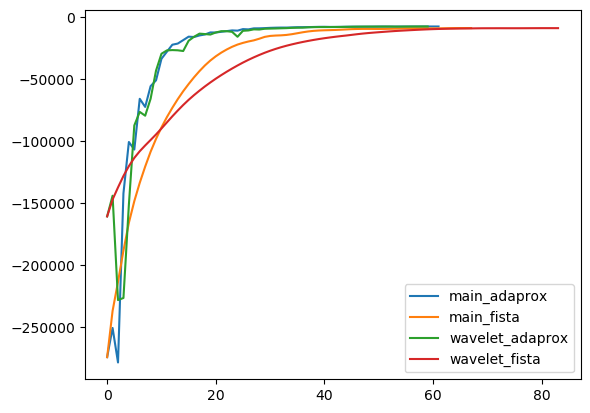

In [14]:
# fit all of the blends
for k, blend in blends.items():
    %time blend.fit(100, e_rel=1e-4, min_iter=20, resize=10, reweight=True)
    print(f"{k} blend completed in {blend.it} iterations from initial logL {blend.loss[0]:.1f} to final logL {blend.loss[-1]:.1f}")
    plt.plot(blend.loss, label=k)
plt.legend()
plt.show()

While the results above show that for this blend the wavelet initialization proved to have a smaller log likelihood but had relatively little affect on the overall fit, preliminary testing has shown that the main initialization seems to be more compatible with ADAPROX while the wavelet initialization seems to perform better with FISTA.

## Displaying the results

Classes in the lite module are not meant to be drop in replacements for their counterparts in main scarlet, primarily because of the difference in design discussed in [Design](#Design). For example, because main scarlet has to be able to reproject observations with potentially overlapping bands at different orientations and pixel scales onto the same common grid, it uses the `scarlet.frame.Frame` object to keep track of the transformations needed to make that update in each iteration. `scarlet.lite` has no need for a `Frame`, so instead of creating unecessary clutter in the `scarlet.display` module, a `scarlet.lite.display` module has been created that mirrors the main scarlet display module, so replacing `from scarlet import display` can be replaced with `from scarlet.lite import display` with little change in functionality.

Here we show the results of all 4 different configurations defined above:

In [15]:
from scarlet.lite import display

stretch = 0.2
Q = 10
norm = display.AsinhMapping(minimum=0, stretch=stretch, Q=Q)
for k, blend in blends.items():
    display.show_scene(
        blend,
        observation,
        show_model=False,
        show_rendered=True,
        show_observed=True,
        show_residual=True,
        norm=norm
    )
    # Show the scene again with the reweighted flux
    display.show_scene(
        blend,
        observation,
        show_model=False,
        show_rendered=True,
        show_observed=True,
        show_residual=True,
        norm=norm,
        use_flux=True
    )
    plt.show()

TypeError: show_scene() got multiple values for argument 'norm'

Next we look at the flux weighted models for one of the blends:

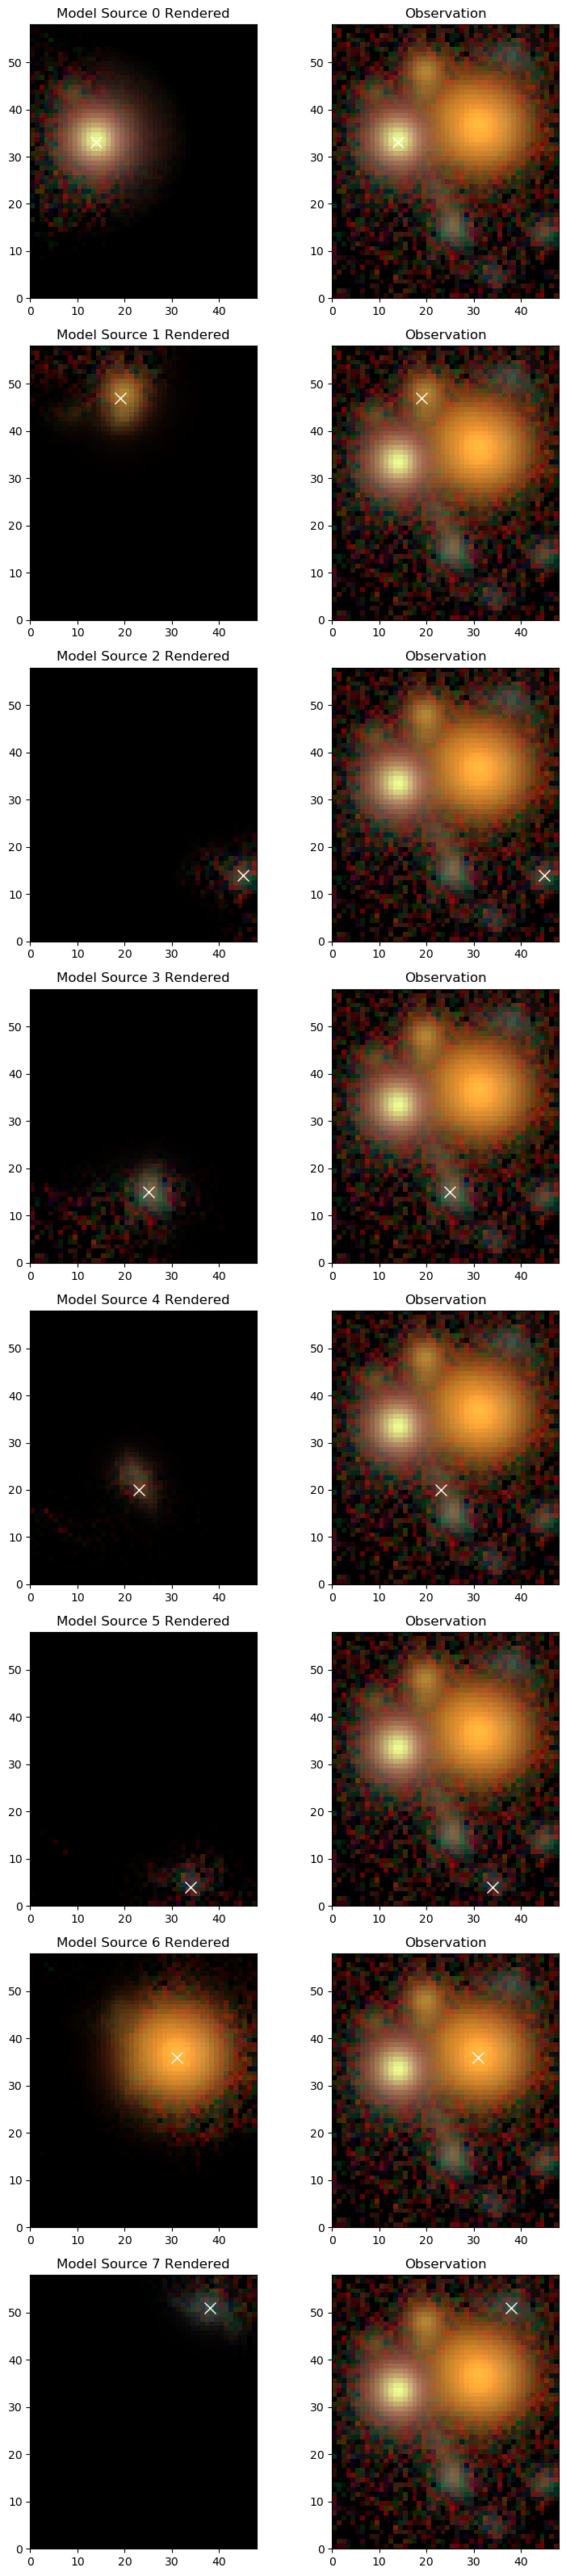

In [16]:
# Display the flux re-distributed models
display.show_sources(blends["wavelet_adaprox"], show_model=False, show_rendered=True, show_observed=True, show_spectrum=False, norm=norm, use_flux=True)
plt.show()

Finally we look at a comparison of the spectra of the different objects to see how they differ by deblending method

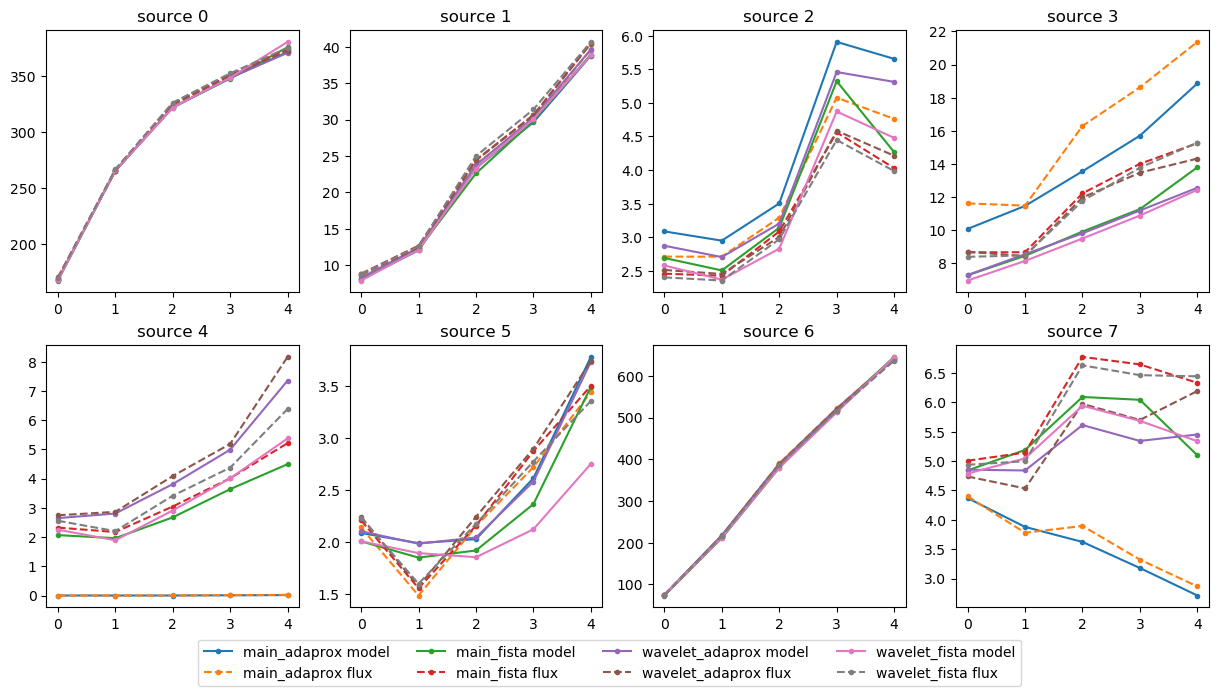

In [17]:
display.compare_spectra(**sources)